In [29]:
from numpy.linalg import inv
from scipy import misc

import warnings
from sklearn.exceptions import ConvergenceWarning

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

import sklearn.preprocessing

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

###########
# import our libraries
from blue_conduit_spatial.utilities import build_datasets
from blue_conduit_spatial.evaluation import *

########### set random state
np.random.seed(297)

########### save the models that we train
import pickle
def load_model_results():
    model_results = {}
    for i in range(100):
        try:
            load_name = f'saved_models/GP_{i}.sav'
            loaded_model = pickle.load(open(load_name, 'rb'))
            model_results[i] = {'model' : loaded_model}
        except Exception:
            pass
    return model_results

def save_model_results(model_results):
    for i, key in enumerate(model_results):
        res = model_results[key]
        #saved_model = pickle.dumps()

        filename = f'saved_models/GP_{i}.sav'
        pickle.dump(res['model'], open(filename, 'wb'))

LAT_MIN, LAT_MAX = 42.97, 43.09
LON_MIN, LON_MAX = -83.75, -83.62


# load data

In [3]:
# this is kinda slow

Xtrain, Xtest, Ytrain, Ytest = build_datasets('../data/flint_sl_materials')

n_train = 1000
n_train_ensemble = 100
n_test_small = 200
n_test_small_ensemble = 100

train_sample_idx = [np.random.choice(np.arange(Xtrain.shape[0]),size=n_train) for i in range(n_train_ensemble)]
features = ['Latitude', 'Longitude']

Xtrains = [Xtrain[features].values[tsi,:] for tsi in train_sample_idx]
Xtest = Xtest[features].values
Ytrains = [Ytrain[['dangerous']].values[tsi].astype(int).flatten() for tsi in train_sample_idx]
Ytest = Ytest[['dangerous']].values.astype(int).flatten()

test_small_idx = [np.random.choice(np.arange(Xtest.shape[0]), size=n_test_small) for i in range(n_test_small_ensemble)]
Xtests_small, Ytests_small = [Xtest[tsi,:] for tsi in test_small_idx], [Ytest[tsi] for tsi in test_small_idx]

Xtrains[0].shape, Ytrains[0].shape, Xtest.shape, Ytest.shape, Xtests_small[0].shape, Ytests_small[0].shape

((1000, 2), (1000,), (6778, 2), (6778,), (200, 2), (200,))

# load saved trained Gaussian Process models

In [24]:
model_results = load_model_results()

sample_model = model_results[0]['model']

# create a mesh to plot in

In [4]:
def plot_model(fig, ax, model, X = None, y = None, title = None):
    
    # setup mesh
    x1v, x2v = np.meshgrid(np.linspace(LAT_MIN, LAT_MAX,100), np.linspace(LON_MIN, LON_MAX,100))
    xgrid = np.c_[x1v.ravel(), x2v.ravel()]

    # predict on the mesh
    ygrid_prob = model.predict_proba(xgrid)[:,1].reshape(x1v.shape)    
    colormesh = ax.pcolormesh(x1v, x2v, ygrid_prob,alpha = 0.8, shading='auto')
    cb = fig.colorbar(colormesh, ax=ax)
    cb.set_label('Probability of DANGEROUS ')
    
    # decision boundary of 0.5
    cs = ax.contour(x1v, x2v, ygrid_prob, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)
    ax.clabel(cs, fontsize=20)
    
    # plot data
    if X is not None and y is not None:
        dangerous_indices = [i for i in range(len(y)) if y[i]==1]
        safe_indices = [i for i in range(len(y)) if y[i]==0]
        ax.scatter(X[dangerous_indices,0], X[dangerous_indices,1], marker= 'x', s=200)
        ax.scatter(X[safe_indices,0], X[safe_indices,1], marker= 'o', s=200, alpha=.1)

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_xlim(LAT_MIN, LAT_MAX)
    ax.set_ylim(LON_MIN, LON_MAX)
    if title:
        ax.set_title(title)
    

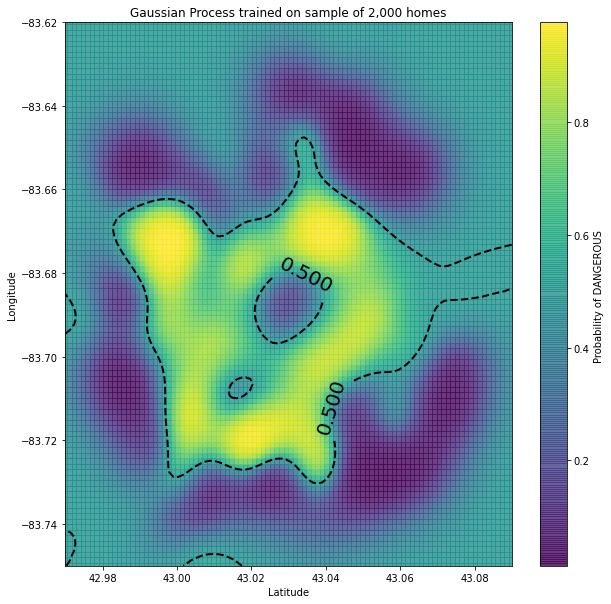

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
plot_model(fig,ax,sample_model, title='Gaussian Process trained on sample of 2,000 homes')
plt.show()

In [30]:
anisotropic_rbf_kernel = 1.0 * RBF([1.0, 1.0])

def plot_random_state_grid(nrows=3, ncols=3, kernel=anisotropic_rbf_kernel, suptitle='Anisotropic RBF kernel'):

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

    for i, r in enumerate(random_states):
        ax = axes[i//ncols, i%ncols]
        x_train, x_test, y_train, y_test = get_train_test(data, 200, random_state=r)
        model = GaussianProcessClassifier(kernel=kernel).fit(x_train,y_train)
        plot_model(fig, ax, model, x_train, y_train, title = f'random state {r}')
    plt.suptitle(suptitle, y=1.01, fontsize=30)
    plt.tight_layout()
    plt.show()
    

In [31]:
def get_hyperparameter_options(nrows, ncols, l_range=[1e-3,3e-3], sigma_range=[1e-8,1e-2]):
    # used to cross-validate between options for GAUSSIAN PROCESS hyperparameters SIGMA and L
    #
    # interpolates linearly between the given min and max for l and sigma
    # using nrows and ncols to determine the number of steps
    l_min, l_max = l_range
    sigma_min, sigma_max = sigma_range
    
    l_options = np.array([[l_min*(l_max/l_min)**(i/(ncols-1))]*2 for i in range(ncols)])
    sigma_options = [sigma_min*(sigma_max/sigma_min)**(i/(nrows-1)) for i in range(nrows)]
    
    hyper_options = [{'sigma' : s, 'l' : l} for s in sigma_options for l in l_options]
    return hyper_options

In [34]:
Xtrains[0]

array([[ 43.04762  , -83.651848 ],
       [ 43.052753 , -83.70313  ],
       [ 43.041198 , -83.644273 ],
       ...,
       [ 43.044648 , -83.651505 ],
       [ 43.0694014, -83.7132396],
       [ 43.008715 , -83.658197 ]])

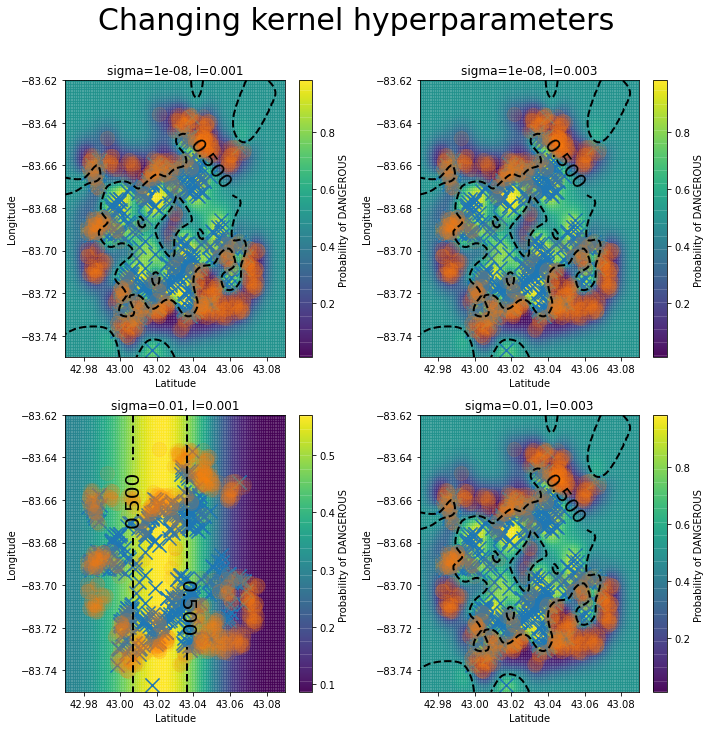

In [33]:
def plot_kernel_grid(nrows=3, ncols=3, suptitle='Changing kernel hyperparameters'):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)

        fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

        x_train, y_train = Xtrains[0], Ytrains[0]

        for i, hyper in enumerate(get_hyperparameter_options(nrows, ncols)):
            s, l = hyper['sigma'], hyper['l']
            ax = axes[i//ncols, i%ncols]
            model = GaussianProcessClassifier(kernel= s*RBF(l)).fit(x_train,y_train)
            plot_model(fig, ax, model, x_train, y_train, title = f'sigma={np.round(s,8)}, l={np.round(l[0],5)}')
        plt.suptitle(suptitle, y=1.01, fontsize=30)
        plt.tight_layout()
        plt.show()

plot_kernel_grid(nrows=2, ncols=2)


# cross validation to try different sklearn GP kernels

In [8]:
def gp_kernel_cross_validation():

    x_train, x_test, y_train, y_test = get_train_test(data, 200, 297)

    model = GaussianProcessClassifier()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    grid = dict()
    grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()]
    # define search
    search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(x_train, y_train)
    
    means = results.cv_results_['mean_test_score']
    params = results.cv_results_['params']
    for mean, param in zip(means, params):
        print("mean test accuracy %.3f with: %r" % (mean, param))
        
#gp_kernel_cross_validation()

In [9]:
matern_kernel = 1.0*Matern(length_scale=1,nu=1.5)
#plot_random_state_grid(kernel = matern_kernel, suptitle='Matern kernel')

# comparing with jared model

(6778,) (6778,)


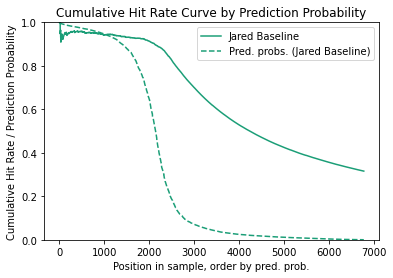

In [10]:
jared_train_pred = pd.read_csv('../data/jared_train_yhat.csv').values
jared_test_pred = pd.read_csv('../data/jared_test_yhat.csv').values
jared_small_train_pred = pd.read_csv('../data/jared_train_yhat_small_train.csv').values
jared_small_test_pred = pd.read_csv('../data/jared_test_yhat_small_train.csv').values
print(Ytest.shape, jared_test_pred[:,1].shape)
plot_hit_rate_curve(Ytest, jared_test_pred[:,1], labels=['Jared Baseline'])

In [11]:
def get_model_results(n_models=10):
    
    # model hyperparameters
    sigma = 1e-3
    l = 1e-3
    kernel = sigma*RBF(l)
    
    model_results = {}
    
    for i in range(n_models):
        
        print(i)
        
        train_d = {}
        test_d = {}

        # choose train and test sample
        # NOTE: using Xtest, Ytest (capital letters) to refer to the main test set of 6,778 homes
        # using xtest, ytest to refer to smaller test sets of 200 homes each (easier for plotting)
        xtrain, ytrain = Xtrains[i], Ytrains[i]

        # fit model
        new_model = GaussianProcessClassifier(kernel=kernel).fit(xtrain,ytrain)

        # predict
        ytrainpred = new_model.predict(xtrain)
        ytrainpred_proba = new_model.predict_proba(xtrain)
        Ytestpred = new_model.predict(Xtest)
        Ytestpred_proba = new_model.predict_proba(Xtest)
        train_d['pred'] = ytrainpred
        test_d['pred'] = Ytestpred

        # calculate metrics
        train_accuracy = accuracy_score(ytrain, ytrainpred)
        test_accuracy = accuracy_score(Ytest, Ytestpred)
        train_precision = precision_score(ytrain, ytrainpred)
        test_precision = precision_score(Ytest, Ytestpred)
        train_recall = recall_score(ytrain, ytrainpred)
        test_recall = recall_score(Ytest, Ytestpred)
        train_auc = roc_auc_score(ytrain, ytrainpred_proba)
        test_auc = roc_auc_score(Ytest, Ytestpred_proba)


        train_d['accuracy'] = train_accuracy
        test_d['accuracy'] = test_accuracy
        train_d['precision'] = train_precision
        test_d['precision'] = test_precision
        train_d['recall'] = train_recall
        test_d['recall'] = test_recall
        train_d['auc'] = train_auc
        test_d['auc'] = test_auc
        
        # only add results if good enough
        if test_auc > 0.7:
            model_results[i] = {'model' : new_model, 'train' : train_d, 'test' : test_d}
    
    return model_results

#model_results = get_model_results(n_models=100)

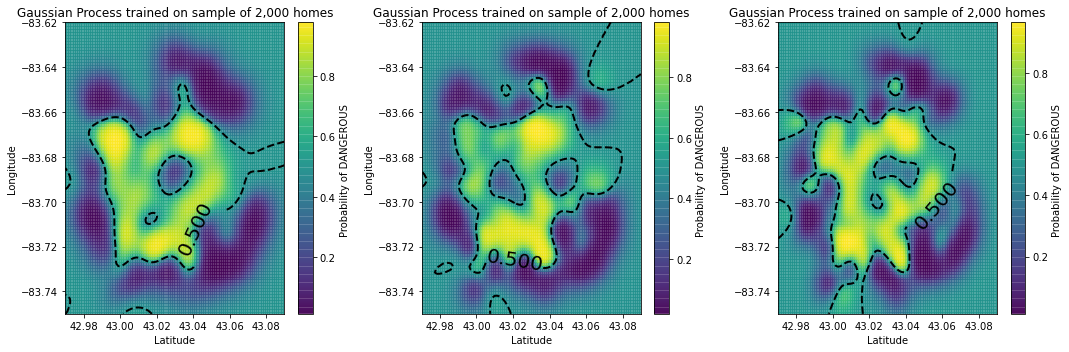

In [38]:
def plot_model_results(model_results, n=None):

    nrows = len(model_results.keys())
    if n:
        ncols = n
    #fig, axes = plt.subplots(2, ncols, figsize=(5*ncols, 10))
    fig, axes = plt.subplots(1, ncols, figsize=(5*ncols, 5))

    for i, key in enumerate(model_results):
        if n:
            if i==n:
                break
        res = model_results[key]
        new_model = res['model']
        #train_title = ('Train AUC ') + str(np.round(res['train']['auc'], 3))
        #test_title = ('Test AUC ') + str(np.round(res['test']['auc'], 3))

        # plot predictions
        plot_model(fig, axes[i], new_model, title='Gaussian Process trained on sample of 2,000 homes')
        #plot_model(fig, axes[i], new_model)
        #plot_model(fig, axes[0,i], new_model, Xtrains[i], Ytrains[i], train_title)
        #plot_model(fig, axes[1,i], new_model, Xtests_small[i], Ytests_small[i], test_title)
        
        


    plt.tight_layout()
    plt.show()

plot_model_results(model_results, n=3) 


In [13]:
def plot_ensemble(model_results):
    
    n_models = len(model_results)
    
    fig, ax = plt.subplots(figsize = (10,10))
    
    # setup mesh
    x1v, x2v = np.meshgrid(np.linspace(LAT_MIN, LAT_MAX,100), np.linspace(LON_MIN, LON_MAX,100))
    xgrid = np.c_[x1v.ravel(), x2v.ravel()]
    meangrid = 0.5 + np.zeros(shape=(100,100))
    ygrid_prob_total = 0

    # predict on the mesh
    for key in model_results:
        if key%10==0:
            print('predicting model with key', key)
        model = model_results[key]['model']
        ygrid_prob = model.predict_proba(xgrid)[:,1].reshape(x1v.shape)
        #sq_dist_to_meangrid = (ygrid_prob - meangrid)**2
        ygrid_prob_total += (1/n_models) * ygrid_prob #* sq_dist_to_meangrid
    colormesh = ax.pcolormesh(x1v, x2v, ygrid_prob_total,alpha = 0.8, shading='auto')
    fig.colorbar(colormesh, ax=ax)
    
    # decision boundary of 0.5
    cs = ax.contour(x1v, x2v, ygrid_prob_total, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)
    ax.clabel(cs, fontsize=20)

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_xlim(LAT_MIN, LAT_MAX)
    ax.set_ylim(LON_MIN, LON_MAX)
    ax.set_title(f'Average of ensemble of {n_models} models')
    
    plt.show()

In [14]:
#plot_ensemble(model_results)

In [21]:

#save_model_results(model_results)

In [22]:
model_results = load_model_results()

In [23]:
model_results

{0: {'model': GaussianProcessClassifier(kernel=0.0316**2 * RBF(length_scale=0.001))},
 1: {'model': GaussianProcessClassifier(kernel=0.0316**2 * RBF(length_scale=0.001))},
 2: {'model': GaussianProcessClassifier(kernel=0.0316**2 * RBF(length_scale=0.001))},
 3: {'model': GaussianProcessClassifier(kernel=0.0316**2 * RBF(length_scale=0.001))},
 4: {'model': GaussianProcessClassifier(kernel=0.0316**2 * RBF(length_scale=0.001))},
 5: {'model': GaussianProcessClassifier(kernel=0.0316**2 * RBF(length_scale=0.001))},
 6: {'model': GaussianProcessClassifier(kernel=0.0316**2 * RBF(length_scale=0.001))},
 7: {'model': GaussianProcessClassifier(kernel=0.0316**2 * RBF(length_scale=0.001))},
 8: {'model': GaussianProcessClassifier(kernel=0.0316**2 * RBF(length_scale=0.001))},
 9: {'model': GaussianProcessClassifier(kernel=0.0316**2 * RBF(length_scale=0.001))},
 10: {'model': GaussianProcessClassifier(kernel=0.0316**2 * RBF(length_scale=0.001))},
 11: {'model': GaussianProcessClassifier(kernel=0.031

In [19]:
i=2
loaded_model = pickle.load(open(f'saved_models/GP_{i}.sav', 'rb'))

In [20]:
loaded_model

GaussianProcessClassifier(kernel=0.0316**2 * RBF(length_scale=0.001))

In [61]:
Ytest[40]

1

1.0

In [71]:
jared_wrong_indices = np.array([i for i in range(len(Ytest)) if Ytest[i]!=np.round(jared_test_pred[:,1][i]).astype(int)])
wrong_indices

array([   0,    6,    9,   17,   21,   23,   24,   25,   26,   32,   63,
         71,   72,   74,   77,   80,   86,   88,   96,  129,  139,  174,
        177,  192,  202,  217,  222,  232,  234,  258,  260,  266,  271,
        278,  279,  281,  284,  285,  287,  289,  305,  318,  352,  362,
        413,  453,  461,  462,  465,  472,  531,  598,  610, 1043, 1066,
       1069, 1071, 1363, 1371, 1406, 1414, 1415, 1460, 1485, 1544, 1547,
       1567, 1571, 1633, 1650, 2093, 2101, 2102, 2112, 2143, 2148, 2165,
       2174, 2176, 2178, 2181, 2192, 2194, 2196, 2197, 2218, 2219, 2241,
       2247, 2260, 2261, 2315, 2323, 2328, 2338, 2352, 2361, 2366, 2381,
       2391, 2392, 2398, 2403, 2419, 2427, 2439, 2442, 2460, 2468, 2484,
       2497, 2503, 2505, 2612, 2621, 2625, 2628, 2629, 2631, 2637, 2641,
       2642, 2643, 2645, 2649, 2650, 2652, 2654, 2655, 2657, 2658, 2660,
       2663, 2667, 2668, 2670, 2671, 2672, 2679, 2681, 2696, 2698, 2702,
       2704, 2706, 2710, 2713, 2714, 2719, 2722, 27

In [68]:
accuracy_score(Ytest,np.round(jared_test_pred[:,1]).astype(int))

0.9346414871643552

In [70]:
1 - 443/6776

0.9346221959858323

In [40]:
def ensemble_predict(x_test, model_results):
    
    mean_prob = 0.5 + np.zeros(x_test.shape[0])
    y_prob_total = 0
    
    n_models = len(model_results)
    # predict on the mesh
    for key in model_results:
        if key%10==0:
            print('predicting model with key', key)
        model = model_results[key]['model']
        y_pred_proba = model.predict_proba(x_test)[:,1]
        sq_dist_to_meangrid = (y_pred_proba - mean_prob)**2
        y_prob_total += (1/n_models) * y_pred_proba #* sq_dist_to_meangrid
    return y_prob_total

#y_pred = ensemble_predict(Xtest, model_results)
#plt.hist(y_pred/(y_pred.max() - y_pred.min()))

predicting model with key 0
predicting model with key 10
predicting model with key 20
predicting model with key 30
predicting model with key 40
predicting model with key 50
predicting model with key 60
predicting model with key 70
predicting model with key 80
predicting model with key 90


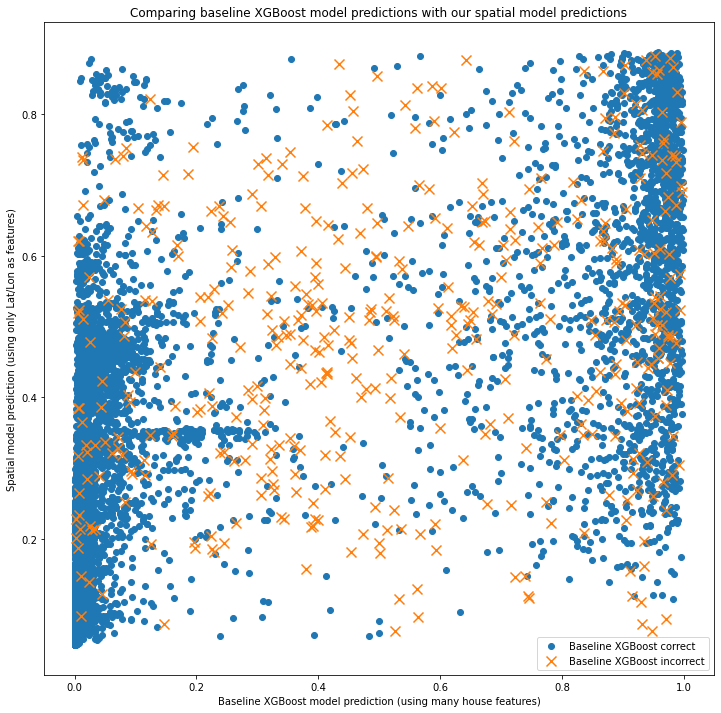

In [41]:
def compare_pred_to_jared(y_pred):
    fig, ax = plt.subplots(figsize=(12,12))



    jared_right_indices = np.array([i for i in range(len(Ytest)) if Ytest[i]==np.round(jared_test_pred[:,1][i]).astype(int)])
    jared_wrong_indices = np.array([i for i in range(len(Ytest)) if Ytest[i]!=np.round(jared_test_pred[:,1][i]).astype(int)])


    ax.scatter(jared_test_pred[jared_right_indices,1], y_pred[jared_right_indices], marker='o', label='Baseline XGBoost correct')
    ax.scatter(jared_test_pred[jared_wrong_indices,1], y_pred[jared_wrong_indices], marker='x', s=100, label='Baseline XGBoost incorrect')
    ax.set_xlabel('Baseline XGBoost model prediction (using many house features)')
    ax.set_ylabel('Spatial model prediction (using only Lat/Lon as features)')
    ax.set_title('Comparing baseline XGBoost model predictions with our spatial model predictions')
    ax.legend()
    plt.show()
#fig, ax = plt.sub
y_pred = ensemble_predict(Xtest, model_results)
compare_pred_to_jared(y_pred)

In [118]:
from sklearn.metrics import roc_auc_score
ensemble_auc = roc_auc_score(Ytest, y_pred)

In [119]:
ensemble_auc

0.8288921925132182

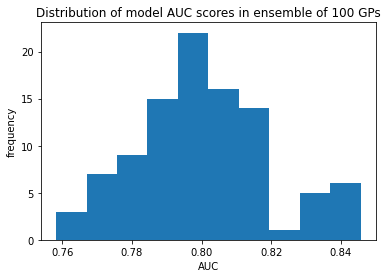

In [126]:
auc_list = [model_results[key]['test']['auc'] for key in model_results]
plt.hist(auc_list)
plt.title('Distribution of model AUC scores in ensemble of 100 GPs')
plt.xlabel('AUC')
plt.ylabel('frequency')
plt.show()